
# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

In [4]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,$ - 0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,$ - 0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,$ - 0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,$ - 0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,$ - 0,01/01/2019


In [ ]:
df.columns = df.columns.str.replace(' ', '_')

#cleaning sale date and turning it into an integer
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
df['SALE_PRICE'] = df['SALE_PRICE'].str.replace(' ', '')
df['SALE_PRICE'] = df['SALE_PRICE'].str.replace('$', '')
df['SALE_PRICE'] = df['SALE_PRICE'].str.replace(',', '')
df['SALE_PRICE'] = pd.to_numeric(df['SALE_PRICE'])
#only keeping sales above 0$
df = df[df['SALE_PRICE'] > 0]

#change land_square_feet to integer
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',', '')
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace('#', '')
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'])

#drop address, ease-ment, and apartment number
df = df.drop(['ADDRESS', 'EASE-MENT', 'APARTMENT_NUMBER', ], axis=1)

#keep only sales with one unit
df = df[df.TOTAL_UNITS == 1]
print(df.shape)

In [6]:
print(df.shape)
df.head()

(7242, 18)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,11427.0,1.0,0.0,1.0,4000.0,2001.0,1940.0,1,A1,200000,2019-01-01
65,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,691,1130,R4,10011.0,1.0,0.0,1.0,18975.0,1077.0,2013.0,2,R4,2000000,2019-01-02
70,1,UPPER WEST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1167,1272,R4,10023.0,1.0,0.0,1.0,28335.0,545.0,1901.0,2,R4,2997613,2019-01-02
71,1,UPPER WEST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1171,2200,R4,10069.0,1.0,0.0,1.0,0.0,827.0,2004.0,2,R4,1250000,2019-01-02


In [7]:
y = df['SALE_PRICE']
X = df.drop(columns=['SALE_PRICE', 'SALE_DATE'])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=42)

In [9]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5069, 16), (2173, 16), (5069,), (2173,))

In [10]:
#baseline

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.04141739530602853


<Axes: title={'center': 'Top 15 features'}>

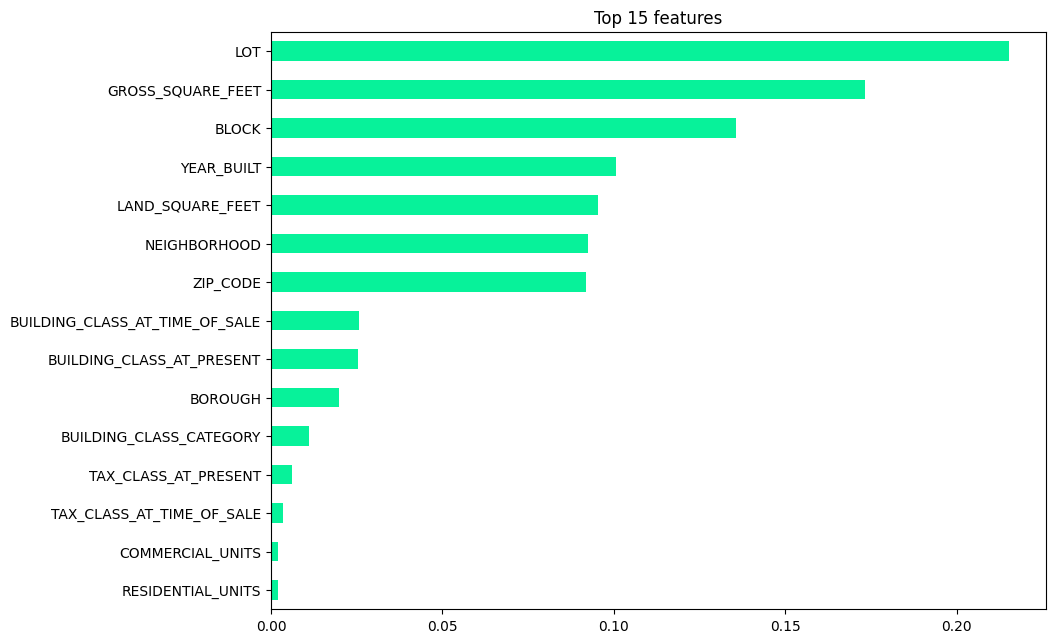

In [11]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 15
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='#07F29A')


#permutation

In [12]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed =transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=5, random_state=42, n_jobs = -1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42)

In [ ]:
!pip install eli5

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(estimator=RandomForestClassifier(n_estimators=5,
                                                       n_jobs=-1,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [15]:
feature_names = X_val.columns.tolist()
feature_names

['BOROUGH',
 'NEIGHBORHOOD',
 'BUILDING_CLASS_CATEGORY',
 'TAX_CLASS_AT_PRESENT',
 'BLOCK',
 'LOT',
 'BUILDING_CLASS_AT_PRESENT',
 'ZIP_CODE',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT',
 'TAX_CLASS_AT_TIME_OF_SALE',
 'BUILDING_CLASS_AT_TIME_OF_SALE']

In [16]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0174 ± 0.0040,YEAR_BUILT
0.0101 ± 0.0030,BLOCK
0.0086 ± 0.0024,ZIP_CODE
0.0075 ± 0.0052,LOT
0.0073 ± 0.0029,NEIGHBORHOOD
0.0061 ± 0.0026,TAX_CLASS_AT_TIME_OF_SALE
0.0060 ± 0.0012,GROSS_SQUARE_FEET
0.0045 ± 0.0015,BOROUGH
0.0036 ± 0.0025,BUILDING_CLASS_AT_TIME_OF_SALE
0.0032 ± 0.0016,BUILDING_CLASS_CATEGORY


In [17]:
minimum = 0
mask = permuter.feature_importances_ > minimum

In [22]:
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True])

In [28]:
X_train.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [33]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Use LabelEncoder to encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create the pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=3, random_state=42, n_jobs=-1)
)

# Fit the pipeline
pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
                                      'TAX_CLASS_AT_PRESENT',
                                      'BUILDING_CLASS_AT_PRESENT',
                                      'BUILDING_CLASS_AT_TIME_OF_SALE'],
                                mapping=[{'col': 'NEIGHBORHOOD',
                                          'data_type': dtype('O'),
                                          'mapping': WILLIAMSBURG-NORTH            1
MIDTOWN CBD                   2
DONGAN HILLS-COLONY           3
WAKEFIELD                     4
SPRINGFIELD GARDENS           5
                           ... 
MELROSE/CONCOURSE           237
UPPE...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=3, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

Text(0, 0.5, 'Feature')

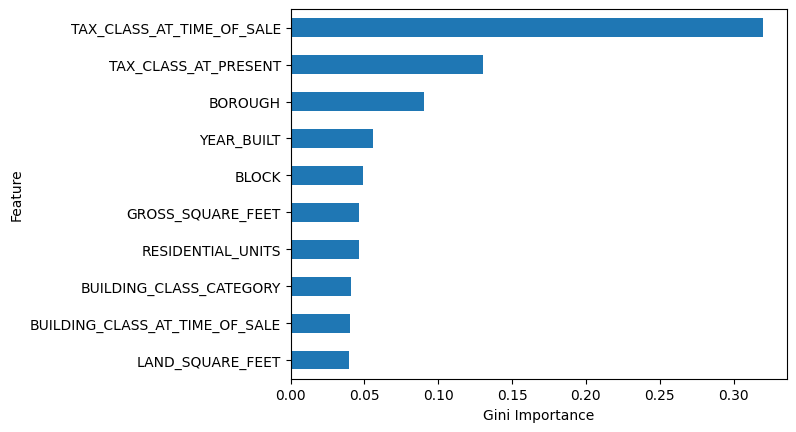

In [35]:
importances = pipeline.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')